In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style('darkgrid')
pd.set_option('display.max_columns',None)
pd.set_option('display.width',None)
pd.set_option('display.max_rows',None)

In [3]:
df = pd.read_csv('Network_anomaly_data.csv')
df['is_attack'] = df['attack'].apply(lambda x: 0 if x=='normal' else 1)
df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag,is_attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,1
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0


In [4]:
scan = set(['ipsweep', 'portsweep', 'nmap', 'satan'])
dos = set(['neptune', 'smurf', 'pod', 'teardrop', 'land'])
access = set(['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezclient', 'warezmaster'])
exploit = set(['buffer_overflow', 'loadmodule', 'rootkit', 'perl'])
backdoor = set(['back','spy'])

df['attack_category'] = None

for i in range(len(df)):
  attk = df.loc[i,'attack']
  if attk in scan:
    df.loc[i,'attack_category'] = 'scan'
  elif attk in dos:
    df.loc[i,'attack_category'] = 'dos'
  elif attk in access:
    df.loc[i,'attack_category'] = 'access'
  elif attk in exploit:
    df.loc[i,'attack_category'] = 'exploit'
  elif attk in backdoor:
    df.loc[i,'attack_category'] = 'backdoor'
  else:
    df.loc[i,'attack_category'] = 'normal'

In [5]:
# Host count of flags
df['dsthostserror'] = df['dsthostcount']*df['dsthostserrorrate']
df['dsthostrerror'] = df['dsthostcount']*df['dsthostrerrorrate']

# Host srv count of flags
df['dsthostsrvserror'] = df['dsthostsrvcount']*df['dsthostsrvrerrorrate']
df['dsthostsrvrerror'] = df['dsthostsrvcount']*df['dsthostsrvserrorrate']

df['dsthostsamesrv'] = df['dsthostsrvcount']*df['dsthostsamesrvrate']
df['dsthostdiffsrv'] = df['dsthostsrvcount']*df['dsthostdiffsrvrate']

# Host count of flags
df['serror'] = df['count']*df['serrorrate']
df['rerror'] = df['count']*df['rerrorrate']

# Host srv count of flags
df['srvserror'] = df['srvcount']*df['srvrerrorrate']
df['srvrerror'] = df['srvcount']*df['srvserrorrate']

df['samesrv'] = df['count']*df['samesrvrate']
df['diffsrv'] = df['count']*df['diffsrvrate']

In [6]:
# land, wrongfragment,urgent, numfailedlogins,loggedin,rootshell,suattempted,numshells,ishostlogin,isguestlogin
df['land'] = df['land'].astype('category')
df['wrongfragment'] = df['wrongfragment'].astype('category')
df['urgent'] = df['urgent'].astype('category')
df['loggedin'] = df['loggedin'].astype('category')
df['rootshell'] = df['rootshell'].astype('category')
df['suattempted'] = df['suattempted'].astype('category')
df['numshells'] = df['numshells'].astype('category')
df['ishostlogin'] = df['ishostlogin'].astype('category')
df['isguestlogin'] = df['isguestlogin'].astype('category')

In [7]:
from sklearn.model_selection import train_test_split

exploit_data = df[df['attack_category'] == 'exploit'].copy()
X = df[df['attack_category'] != 'exploit'].drop(['is_attack','attack','attack_category'],axis=1)
y = df[df['attack_category'] != 'exploit']['is_attack']


exp_test = np.random.choice(exploit_data.index,18,replace=False)
exp_train = exploit_data[~exploit_data.index.isin(exp_test)].index

exp_train_df = df[df.index.isin(exp_train)].drop(['is_attack','attack','attack_category'],axis=1)
exp_test_df = df[df.index.isin(exp_test)].drop(['is_attack','attack','attack_category'],axis=1)

trainx,testx,trainy,testy = train_test_split(X,y, test_size=0.2, random_state=42)

X_train = pd.concat([trainx,exp_train_df])
X_test = pd.concat([testx,exp_test_df])

y_test_ones = pd.DataFrame([1 for i in range(len(exp_test))],columns=['is_attack'],index=exp_test)
y_train_ones = pd.DataFrame([1 for i in range(len(exp_train))],columns=['is_attack'],index=exp_train)

y_train = pd.concat([trainy,y_train_ones])
y_test = pd.concat([testy,y_test_ones])

In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

categorical_columns = ['protocoltype', 'service', 'flag','land','wrongfragment','urgent','loggedin','rootshell','suattempted','numshells',
                       'ishostlogin','isguestlogin']

encoder = LabelEncoder()
for col in categorical_columns:
    X_train[col] = encoder.fit_transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])

In [9]:
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [10]:
from sklearn.ensemble  import RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced',random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


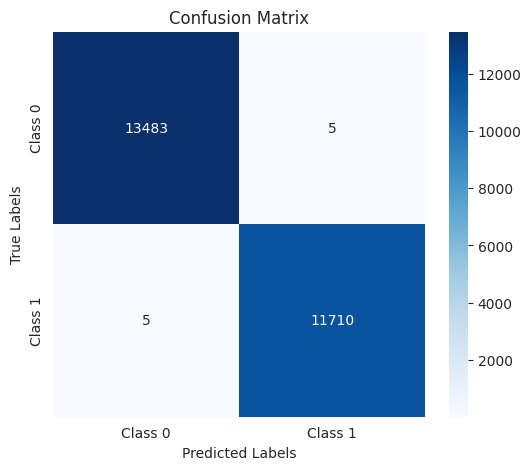

In [11]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,target_names=['normal','attack']))

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00     13488
      attack       1.00      1.00      1.00     11715

    accuracy                           1.00     25203
   macro avg       1.00      1.00      1.00     25203
weighted avg       1.00      1.00      1.00     25203



In [22]:
y_pred_df = pd.DataFrame(y_pred,index=y_test.index)
y_pred_df.isna().sum()

,0
0,0


In [23]:
combined_pred = pd.concat([y_test,y_pred_df],axis=1)
combined_pred.columns = ['is_attack','is_attack_pred']
predicted_probabilities = rf.predict_proba(X_test)
combined_pred['predict_prob'] = predicted_probabilities[:, 1]

In [24]:
combined_pred[combined_pred['is_attack'] != combined_pred['is_attack_pred']]

,is_attack,is_attack_pred,predict_prob
112222,0,1,0.52
62345,0,1,0.56
62967,0,1,0.70
57549,0,1,0.88
80068,0,1,0.55
35434,1,0,0.32
81558,1,0,0.38
1143,1,0,0.46
56279,1,0,0.48
101585,1,0,0.43


In [25]:
combined_pred.shape

(25203, 3)

In [26]:
combined_pred = combined_pred[np.logical_or(combined_pred['is_attack'] == combined_pred['is_attack_pred'],combined_pred['predict_prob'] > 0.90)]

In [27]:
combined_pred.shape

(25193, 3)

In [28]:
op = pd.merge(X_test,combined_pred,left_index=True,right_index=True)
op = pd.merge(op,df['attack_category'],left_index=True,right_index=True)
op.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,dsthostserror,dsthostrerror,dsthostsrvserror,dsthostsrvrerror,dsthostsamesrv,dsthostdiffsrv,serror,rerror,srvserror,srvrerror,samesrv,diffsrv,is_attack,is_attack_pred,predict_prob,attack_category
117039,-0.109638,-0.125031,1.209281,-0.737176,-0.008322,-0.005335,-0.014089,-0.091397,-0.008191,-0.095045,-0.02674,-0.808905,-0.019155,-0.036897,-0.02463,-0.019464,-0.0262,-0.017653,-0.042446,0.0,-0.00315,-0.097711,1.291845,-0.340287,1.598564,1.600857,-0.373019,-0.373044,-1.477603,-0.017136,-0.37445,0.733837,-1.017025,-1.138034,-0.173934,-0.479816,-0.289832,1.604198,1.614207,-0.386382,-0.375246,0.651517,1.650749,-0.341695,-0.173553,-0.121958,-0.910532,-0.262672,2.106147,-0.251237,-0.240963,-0.009583,-0.309347,0.077139,1,1,1.0,dos
71266,-0.109638,-0.125031,2.311214,-0.737176,-0.008322,-0.005335,-0.014089,-0.091397,-0.008191,-0.095045,-0.02674,-0.808905,-0.019155,-0.036897,-0.02463,-0.019464,-0.0262,-0.017653,-0.042446,0.0,-0.00315,-0.097711,1.300582,-0.146353,1.598564,1.600857,-0.373019,-0.373044,-1.341231,-0.017136,-0.37445,0.733837,-0.890576,-1.004418,-0.068226,-0.479816,-0.289832,1.604198,1.614207,-0.386382,-0.375246,-0.220298,1.650749,-0.341695,-0.173553,1.272455,-0.900451,-0.047448,2.117564,-0.251237,-0.240963,2.300728,-0.107837,0.078317,1,1,1.0,dos
26347,-0.109638,-0.125031,-0.443618,0.751744,-0.008274,-0.005276,-0.014089,-0.091397,-0.008191,-0.095045,-0.02674,1.236240,-0.019155,-0.036897,-0.02463,-0.019464,-0.0262,-0.017653,-0.042446,0.0,-0.00315,-0.097711,-0.691328,-0.312582,-0.638937,-0.633621,-0.373019,-0.373044,0.772529,-0.349415,-0.37445,0.733837,1.259043,1.066630,-0.438202,-0.479816,-0.289832,-0.641381,-0.626653,-0.386382,-0.375246,0.651517,-0.627385,-0.341695,-0.173553,-0.420761,1.305340,-0.293714,-0.542633,-0.251237,-0.240963,-0.504650,-0.270745,-0.196153,0,0,0.0,normal
53783,-0.109638,-0.125031,1.086844,-0.737176,-0.008322,-0.005335,-0.014089,-0.091397,-0.008191,-0.095045,-0.02674,-0.808905,-0.019155,-0.036897,-0.02463,-0.019464,-0.0262,-0.017653,-0.042446,0.0,-0.00315,-0.097711,1.213217,-0.187910,1.598564,1.600857,-0.373019,-0.373044,-1.363960,-0.017136,-0.37445,0.733837,-0.881544,-1.004418,-0.068226,-0.479816,-0.289832,1.604198,1.614207,-0.386382,-0.375246,0.651517,1.650749,-0.341695,-0.173553,1.372056,-0.899843,-0.032962,2.003392,-0.251237,-0.240963,1.805662,-0.150040,0.066537,1,1,1.0,dos
19960,-0.109638,-0.125031,-0.443618,0.751744,-0.008293,-0.001993,-0.014089,-0.091397,-0.008191,-0.095045,-0.02674,1.236240,-0.019155,-0.036897,-0.02463,-0.019464,-0.0262,-0.017653,-0.042446,0.0,-0.00315,-0.097711,-0.726273,-0.367992,-0.638937,-0.633621,-0.373019,-0.373044,0.772529,-0.349415,-0.37445,0.733837,1.259043,1.066630,-0.438202,-0.479816,-0.289832,-0.641381,-0.626653,-0.386382,-0.375246,0.651517,-0.627385,-0.341695,-0.173553,-0.420761,1.305340,-0.293714,-0.542633,-0.251237,-0.240963,-0.504650,-0.328361,-0.196153,0,0,0.0,normal


In [29]:
attacks = op[op['is_attack_pred'] == 1].copy()
attacks['attack_category'].value_counts()

,count
attack_category,
dos,8950
scan,2367
backdoor,208
access,168
exploit,17


In [37]:
attacks.isna().sum().sum()

0

In [42]:
exploit_data2 = attacks[attacks['attack_category'] == 'exploit'].copy()

X1 = attacks[attacks['attack_category'] != 'exploit'].drop(['is_attack','is_attack_pred','attack_category','predict_prob'],axis=1)
y1 = attacks[attacks['attack_category'] != 'exploit']['attack_category']


exp_test2 = np.random.choice(exploit_data2.index,9,replace=False)
exp_train2 = exploit_data2[~exploit_data2.index.isin(exp_test2)].index

exp_train2_df = attacks[attacks.index.isin(exp_train2)].drop(['is_attack','is_attack_pred','attack_category','predict_prob'],axis=1)
exp_test2_df = attacks[attacks.index.isin(exp_test2)].drop(['is_attack','is_attack_pred','attack_category','predict_prob'],axis=1)

trainx,testx,trainy,testy = train_test_split(X1,y1, test_size=0.3, random_state=42)

X1_train = pd.concat([trainx,exp_train2_df])
X1_test = pd.concat([testx,exp_test2_df])

y1_test_ones = pd.Series(['exploit' for i in range(len(exp_test2))],index=exp_test2)
y1_train_ones = pd.Series(['exploit' for i in range(len(exp_train2))],index=exp_train2)

y1_train = pd.concat([trainy,y1_train_ones])
y1_test = pd.concat([testy,y1_test_ones])

In [45]:
label_encoder = LabelEncoder()
label_encoder.fit(y1_train)


# Add the 'unknown' category for unseen labels
unknown_class = 'normal'

# Get the current classes from the encoder and add 'unknown' class
classes_ = np.append(label_encoder.classes_, unknown_class)

# Function to handle unseen labels
def safe_transform(y, label_encoder, classes_):
    encoded_labels = []
    for label in y:
        if label in label_encoder.classes_:
            encoded_labels.append(label_encoder.transform([label])[0])
        else:
            # If label is unseen, map it to the 'unknown' category
            encoded_labels.append(len(classes_) - 1)  # This is the index of 'unknown'
    return np.array(encoded_labels)

# Transform the training and test data
y1_train_encoded = safe_transform(y1_train, label_encoder, classes_)
y1_test_encoded = safe_transform(y1_test, label_encoder, classes_)

In [47]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42,k_neighbors=5)
X1_train_smt, y1_train_smt = smote.fit_resample(X1_train, y1_train_encoded)

In [48]:
from sklearn.ensemble  import RandomForestClassifier
rf1 = RandomForestClassifier(class_weight='balanced',random_state=42)
rf1.fit(X1_train_smt, y1_train_smt)
y_pred1= rf1.predict(X1_test)

In [49]:
name_labels = [label_encoder.classes_[i] for i in range(0,5)]

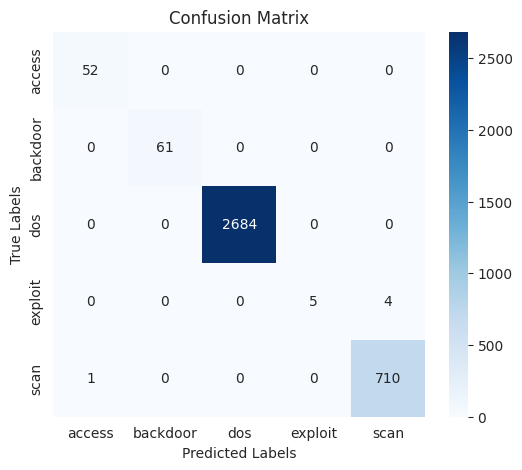

In [50]:
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y1_test_encoded, y_pred1)

plt.figure(figsize=(6, 5))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=name_labels, yticklabels=name_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [51]:
print(classification_report(y1_test_encoded, y_pred1))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       1.00      1.00      1.00        61
           2       1.00      1.00      1.00      2684
           3       1.00      0.56      0.71         9
           4       0.99      1.00      1.00       711

    accuracy                           1.00      3517
   macro avg       1.00      0.91      0.94      3517
weighted avg       1.00      1.00      1.00      3517



In [52]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [50,100, 150,200],
    'max_depth': [None, 10, 20,30,40],
    'min_samples_split': [2, 5, 7,10]
}

grid_search = GridSearchCV(rf1, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X1_train_smt, y1_train_smt)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30, 40],
                         'min_samples_split': [2, 5, 7, 10],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='accuracy')